<h1>Problem</h1>

A supplier is shipping N different parts to Tesla.
 
Every part has a known (deterministic) demand every day.  That is, we know how many parts we will need to build the cars scheduled for production that day.
 
Each part comes in a box with a certain given quantity, and a certain known volume for the box.
 
Parts are delivered in trucks. The truck cost is essentially fixed per truck, that is regardless of whether a truck is half full or completely full the cost is the same. For simplicity, we can model the truck has having a known max volume capacity, and the sum of the volumes of the parts in the truck has to be less than this capacity. (Obviously this is a simplification, in reality fitting the most number of boxes in a truck is a more complex problem)
 
Unused parts from one day carry forward to the next day. We must never run out of a part completely, but other than that generally less inventory is preferred over more.
 
Questions.
1.       Formulate as a Mixed Integer Program the problem of ordering the right number of parts and scheduling the right number of trucks.
2.       Discuss what are the key tradeoffs in this problem and how will different parameters influence the nature of the optimal solution.

<h1>Solution</h1>

**Assumptions**

- Trucks arrive in the early morning before production begins (meaning that the deliveries can be used to fulfill demand on the same day)

- Were only looking to optimize out for D days (due to fluxuating demand)

**Data**

h<sub>n,0</sub> = <em>"init_stock"</em> = initial stock of part n

d<sub>n,d</sub> = <em>"daily_demand"</em> = demand of part n on day d

v<sub>T</sub> = <em>"truck_vol"</em> = volume of truck (cubic ft)

q<sub>n</sub> = <em>"box_qty"</em> = qty of box of part n

v<sub>n</sub> = <em>"box_vol"</em> = vol of box of part n (cubic ft)

c<sub>d</sub> = <em>"load_cost"</em> = shipping cost for a 53-ft truck that arrives on day d

w<sub>n</sub> = <em>"storage_cost"</em> = nightly cost of holding one box of part n

**Decision Variables**

x<sub>n,d</sub> = <em>"boxes_arriving"</em> = boxes of part n arriving on day d

t<sub>d</sub> = <em>"trucks_arriving"</em> = amount of trucks arriving on day d

h<sub>n,d</sub> = <em>"qty_held" </em>= qty of part n held overnight from day d to d+1

**Objective Function**

__min__ $\sum_{d=1}^{D} (c_d * t_d) + \sum_{d=1}^{D} \sum_{n=0}^{N} (w_n*h_{n,d})$

_ (cost of trucks) + (cost of holding material)_

**Constraints**

Conserve inventory: $h_{n,d}=h_{n,d-1} + (x_{n,d}*q_n) - d_{n,d} \forall  d \in {1,...,D}, n \in {0,...,N} $

_parts held overnight = previously held parts + parts arriving - part demand for the day_

Required truck capacity: $t_d*v_T\geq \sum_{n=0}^{N} x_{n,d}*v_n \forall d \in {1,...,D}$

_trucks arriving on a day * volume of a truck >= combined volume of all parts arriving on that day_

Meet daily demand: $x_{n,d}*q_n + h_{n,d-1} \geq d_{n,d} \forall d \in {1,...,D}, n \in {0,...,N}$

_parts arriving + previously held parts >= part demand for the day_

$x_{n,d } \geq 0 \forall d \in {1,...,D}, n \in {0,...,N}$

$t_{d } \geq 0 \forall d \in {1,...,D}, n \in {0,...,N}$

$h_{n,d} \geq 0 \forall d \in {1,...,D}, n \in {0,...,N}$



In [38]:
import numpy as np
from numpy import *
from gurobipy import *
import pandas as pd

#Deterministic data (demand and initial values) import from static excel file 
currentDir = '/Users/connerreinhardt/Google Drive/Advanced Optimization/TeslaChallenge/'
deterministic_data_filepath = currentDir + 'DeterministicDemand.xlsx'
demand_data = pd.read_excel(deterministic_data_filepath).fillna(0)

print(demand_data)

N = len(demand_data['Part'].values) #find out the total number of parts
D = len(demand_data.values[0])-2 #not include day 0 or the part itself

#populate N parts
parts = [] 
for part in range(N):
    parts.append(part)

#plan for the next D days (day 0 is the initial day)
days = []
for day in range(1,D+1):
    days.append(day)

    Part  Day 0 Stock  Day 1 Demand  Day 2 Demand  Day 3 Demand  Day 4 Demand  \
0      0          250         100.0         100.0         100.0         100.0   
1      1          400           0.0         250.0           0.0         250.0   
2      2          350          50.0         100.0          50.0         100.0   
3      3          250           0.0           0.0         300.0           0.0   
4      4           75           0.0          25.0          25.0          25.0   
5      5           10           0.0          50.0           0.0           0.0   
6      6            5          25.0          50.0          50.0          50.0   
7      7          200           0.0         150.0           0.0         150.0   
8      8           50          10.0          10.0          10.0          10.0   
9      9           24           0.0          12.0          24.0          12.0   
10    10           10           5.0          10.0          10.0          10.0   
11    11          200       

In [2]:
#populate arrays with the above info for demand and init stock
init_stock = list(demand_data['Day 0 Stock']) #get values from deterministic table
#init_stock = [] 

#for part in parts: #define from a uniform random qty: 1-100
    #init_stock.append(np.random.randint(0,high=250)) 
    
#print(init_stock)
demand_data = demand_data.drop(columns=['Part', 'Day 0 Stock']) #drop deterministic init values, leaving only demand

#define daily demands per part for the next 7 days (imported from a csv file)
daily_demand = []
for part in parts:
    part_dem = demand_data.values[part].tolist()
    day_demand = [None]
    for dem in part_dem:
        day_demand.append(dem)
    #print("Part " + str(part) + ": " + str(day_demand))
    daily_demand.append(day_demand)

In [165]:
#create model from formulation above
def optimalTruckSchedule(box_qty,
                      box_vol,
                      load_cost,
                      stortage_cost_cuft,
                      daily_demand,
                      init_stock,
                      truck_vol):
    storage_cost_cuft_nightly = stortage_cost_cuft/365
    
    #nightly storage costs for a box of part N
    storage_cost = []
    for part in parts:
        box_storage_cost = box_vol[part]*storage_cost_cuft_nightly
        piece_storage_cost = box_storage_cost / box_qty[part]
        storage_cost.append(piece_storage_cost)


    #create model
    m = Model("ConnerTesla")
    m.setParam('OutputFlag', 0)

    #decision variables
    boxes_arriving = m.addVars(parts,days,name="x",vtype=GRB.INTEGER) #boxes of part N to arrive on day D
    trucks_arriving = m.addVars(days,name="t",vtype=GRB.INTEGER) #trucks arriving on day D
    qty_held = m.addVars(parts,days,name="h",vtype=GRB.INTEGER) #qty of part N stored from day D to D+1

    #objective function
    total_trucking_cost = sum(load_cost[d] * trucks_arriving[d] for d in days)
    total_holding_cost = sum(storage_cost[day]*qty_held[part,day] for part in parts for day in days)
    total_cost = total_trucking_cost + total_holding_cost

    m.setObjective(total_cost, GRB.MINIMIZE)

    #constraints

    for n in parts:
        for d in days:
            if d == 1: #use init stock for the first day

                #conserve inventory constraint
                m.addConstr(qty_held[n,d] == init_stock[n] + (boxes_arriving[n,d]*box_qty[n]) - daily_demand[n][d])

                #meet daily demand constraint
                m.addConstr(init_stock[n]+(boxes_arriving[n,d]*box_qty[n]) >= daily_demand[n][d])

            else: #use previous holdings otherwise

                #conserve inventory constraint
                m.addConstr(qty_held[n,d] == qty_held[n,(d-1)] + (boxes_arriving[n,d]*box_qty[n]) - daily_demand[n][d])

                #meet daily demand constraint
                m.addConstr(qty_held[n,(d-1)]+(boxes_arriving[n,d]*box_qty[n]) >= daily_demand[n][d])


    for d in days:
        #required truck capacity constraint
        m.addConstr(trucks_arriving[d] * truck_vol >= sum((boxes_arriving[n,d]*box_vol[n]) for n in parts))
        m.addConstr(trucks_arriving[d]>=0)

    for n in parts:
        for d in days:
            m.addConstr(qty_held[n,d]>=0)
            m.addConstr(boxes_arriving[n,d]>=0)

    m.optimize()
    
    #return truck info
    truck_plan = []
    truck_cost = []
    for d in days:
        truck_plan.append(trucks_arriving[d].X)
        truck_cost.append(load_cost[d])

    truck_arr = []
    truck_arr.append(truck_plan) #output 0
    truck_arr.append(truck_cost) #output 1
    
    #return parts plan info
    parts_plan = [] #qty amounts
    parts_plan_vol = []

    for n in parts:
        part_plan = [init_stock[n]]
        part_plan_vol = []
        for d in days:
            part_plan.append(boxes_arriving[n,d].X*box_qty[n])
            part_plan_vol.append(boxes_arriving[n,d].X*box_vol[n])
        parts_plan.append(part_plan)
        parts_plan_vol.append(part_plan_vol)
    
    #calculate cube utilization
    cube_util = [] #populate with daily cube ute
    total_volcapacity = 0
    total_partvol = 0
    for d in range(len(truck_plan)):
        daily_volcapacity = truck_plan[d]*truck_vol
        total_volcapacity = total_volcapacity + daily_volcapacity
        daily_partvol = 0
        for n in parts:
            daily_partvol = daily_partvol + parts_plan_vol[n][d]
        total_partvol = total_partvol + daily_partvol
        if daily_volcapacity == 0:
            cube_util_day = 0
        else: 
            cube_util_day = daily_partvol / daily_volcapacity
        cube_util.append(cube_util_day)
    
    avg_cube_util = total_partvol / total_volcapacity #populate with average cube ute
        
    truck_arr.append(parts_plan) #output 2
    
    truck_arr.append(m.objVal) #output 3
    
    truck_arr.append(total_trucking_cost) #output 4
      
    truck_arr.append(cube_util) #output 5
    
    truck_arr.append(avg_cube_util) #output 6
    
    return truck_arr

In [198]:
#define quantity per box of part N
box_qty = []
for part in parts:
    box_qty.append(np.random.choice([2,5,10,12,25]))
print("Part Box Qtys:")
print(box_qty)

#define box volume of part N (cubic feet)
box_vol = []
for part in parts:
    box_vol.append(np.random.randint(3.48,high=348)) #max box vol capped to 1/10 of truck size
print("Part Box Vols (CuFt):")
print(box_vol)

Part Box Qtys:
[25, 10, 25, 2, 10, 10, 5, 25, 5, 25, 12, 2]
Part Box Vols (CuFt):
[264, 119, 256, 61, 298, 293, 138, 282, 181, 173, 294, 50]


In [206]:
#suggest cost per truck arriving day D
load_cost = [None]
load_cost_min = 2500
load_cost_max = 3500
for day in days:
    load_cost.append(np.random.randint(load_cost_min,load_cost_max))
print(load_cost)

[None, 3125, 3190, 2585, 3441, 3351, 3047, 3393]


 Total Cost:  $59226
--> Trucking: $41025
--> Holding:  $18201

 Avg Cube Utilization: 95.3%


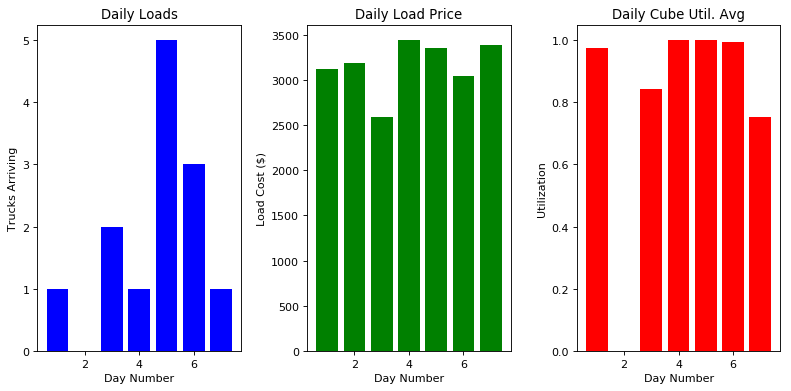

In [209]:
import matplotlib.pyplot as plt

#run model for a given scenerio
modeloutput = optimalTruckSchedule(
    #parts 0,1,2,...,N
    [25, 10, 25, 2, 10, 10, 5, 25, 5, 25, 12, 2], #box qtys
    [264, 119, 256, 61, 298, 293, 138, 282, 181, 173, 294, 50], #box vols
    #days 0 (no trucks), 1, 2,...,D
    [None, 3125, 3190, 2585, 3441, 3351, 3047, 3393], #**load costs
    106.5, #**yearly holding cost per CuFt ($6.5 is US avg for storage) **Holding costs + opportunity cost**
    daily_demand, #(deterministic) from file
    init_stock, #(deterministic) from file
    3489 #truckvol
    ) 

truckschedule = modeloutput[0] #how many trucks per day
truckpricing = modeloutput[1] #price of truck per day
partschedule = pd.DataFrame(modeloutput[2]) #how many of each part per day
total_cost = modeloutput[3]
cube_util = modeloutput[5]
cube_util_avg = modeloutput[6]

print("\033[1m Total Cost:  $" + str(round(total_cost)) + "\033[0m")

#identify total trucking cost vs holding cost
total_trucking_cost = 0
for day in range(len(truckschedule)):
    day_truck_cost = truckschedule[day]*truckpricing[day]
    total_trucking_cost = total_trucking_cost + day_truck_cost
    
print("--> Trucking: $" + str(round(total_trucking_cost)))
print("--> Holding:  $" + str(round(total_cost-total_trucking_cost)))

print("\n\033[1m Avg Cube Utilization: " + str(round(100*cube_util_avg,1)) + "%\033[0m")

#plot results
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.bar(days,truckschedule,color = 'blue')
plt.title('Daily Loads')
plt.ylabel('Trucks Arriving')
plt.xlabel('Day Number')
plt.subplot(1, 3, 2)
plt.bar(days,truckpricing,color = 'green')
plt.title('Daily Load Price')
plt.ylabel('Load Cost ($)')
plt.xlabel('Day Number')
plt.subplot(1, 3, 3)
plt.bar(days,cube_util, color = 'red')
plt.title('Daily Cube Util. Avg')
plt.ylabel('Utilization')
plt.xlabel('Day Number')
plt.tight_layout()
plt.show()

In [210]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print("        Part Arrival Schedule                         Part Qty Demand")
print("                         (Day 0 = Init Qty, Rows=Parts)              ")
display_side_by_side(partschedule,pd.DataFrame(daily_demand))

        Part Arrival Schedule                         Part Qty Demand
                         (Day 0 = Init Qty, Rows=Parts)              


,0,1,2,3,4,5,6,7
0,250,0.0,0.0,50.0,100.0,100.0,100.0,100.0
1,400,0.0,0.0,-0.0,100.0,-0.0,250.0,-0.0
2,350,0.0,0.0,0.0,0.0,0.0,100.0,50.0
3,250,-0.0,0.0,60.0,2.0,288.0,-0.0,-0.0
4,75,0.0,0.0,-0.0,0.0,30.0,20.0,-0.0
5,10,40.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,5,70.0,0.0,100.0,0.0,60.0,40.0,25.0
7,200,0.0,0.0,0.0,100.0,0.0,250.0,-0.0
8,50,0.0,0.0,0.0,-0.0,-0.0,10.0,10.0
9,24,0.0,0.0,25.0,0.0,25.0,25.0,-0.0
